In [1]:
# 1

########## 24 February 2019 - Alec S. Hirschauer ##########
# This will be the Python notebook used for identifying
# AGB star candidates in NGC 6822 using a [8.0] vs [3.6]-[8.0]
# CMD with data from the Sibbons et al. (2012) WFCAM/UKIRT
# catalog in preparation for the Dusting the Universe
# conference which takes place in March 2019.
#
# Effectively the FOURTH iteration in evolution of this analysis,
# we are attempting to be more considerate of accounting for
# uncertainties in the determination of the color-cut boundaries.
#
# Sundar Srinivasan is currently visiting STScI (22-25 Jan 2019)
# and is helping figure out how to include the photometric
# uncertainties into the KDE analysis.
#
# Future notebooks will be based on this one, but will tackle
# additional CMDs, in no particular order:
# [3.6] vs J-[3.6] <- *THIS ONE*
# [8.0] vs [3.6]-[8.0]
# [24] vs [8.0]-[24]
# [8.0] vs J-[8.0]
# [3.6] vs [3.6]-[4.5]
# [8.0] vs [4.5]-[8.0]
#
# ^ Some of the above may be more or less useful than others,
#   but if we can get the whole process automated, then in
#   principle it wouldn't take much more time to do them all.
#
# The various populations include:
# (1) O-rich/M-type AGB star candidates
# (2) C-rich/C-type AGB star candidates
# (3) the first dusty track of O-rich AGB stars
# (4) extremely dusty sources (included with C-types)
#
# ^ Population (4) is likely some C-types + YSOs
#
# Also NB that we will detect plenty of RSG stars at similar colors
# as the AGB stars, but at lower (brighter) magnitudes.
#
# All this will be accomplished by determining first the TRGB,
# which Cioni & Habing (2005) says is at K_s = 17.10 +/- 0.01
# but Sibbons et al. (2012) says is at K_0 = 17.41 +/- 0.11.
#
# ^ TRGB for this CMD not known from the literature.
#
# I will employ histograms fit with KDE Gaussians to find the
# local minima inflection point over the relevant range of data.
#
# This technique will then also be used to determine the color cuts
# between the various populations as measured by histograms of
# optimum bin width as determined by Knuth's Algorithm.
#
# The Monte Carlo Kernel Density Estimation (MCKDE) method that we
# are developing is unfortunately probably not going to be ready
# by the time I present on 4 March 2019, so I'm going to try to
# make color cuts based on the MCKDE TRGB analysis and then
# my technique of estimating the local minima of inflection points.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.
from sklearn import neighbors
from scipy.signal import savgol_filter
# These lines are from Sundar's KDE routine

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
threesixMINUSeightzeroALL = pd.read_csv('threesixMINUSeightzeroALL.csv')

# below aren't useful yet, hold tight
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
threesixMINUSfourfiveDATA = pd.read_csv('threesixMINUSfourfive.csv')
#
# ^ Note that only the third file is necessary for THIS notebook.

In [5]:
# 5

# The first thing I'll do here is make the [8.0] vs [3.6]-[8.0] CMD & Hess diagram.

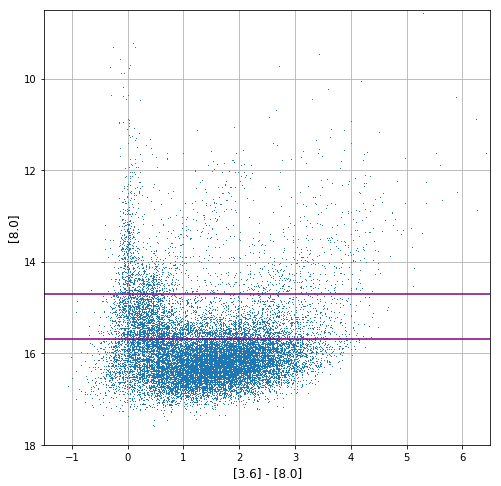

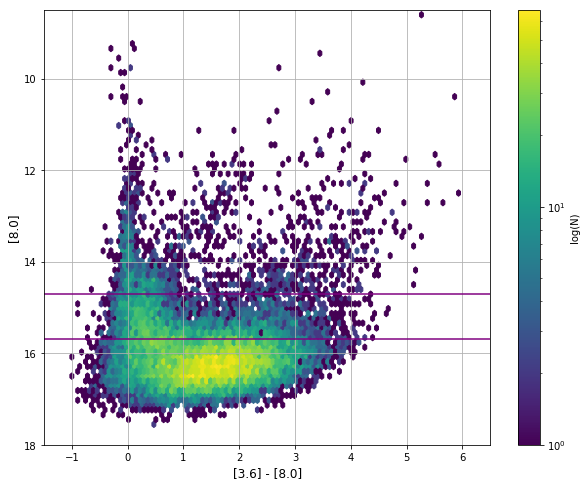

In [6]:
# 6

# [8.0] vs [3.6]-[8.0]
# CMD & Hess diagram
#
plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, ',')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')
plt.grid(True)
plt.show()
plt.close()

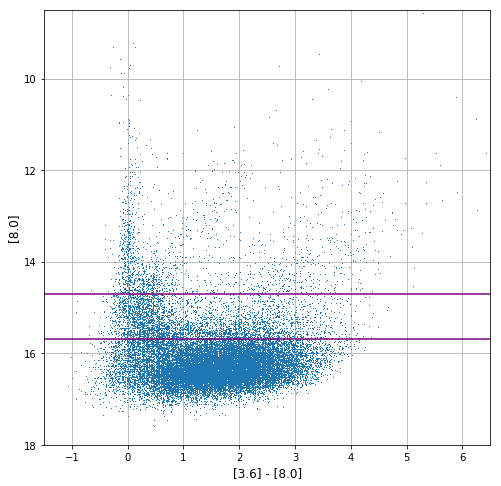

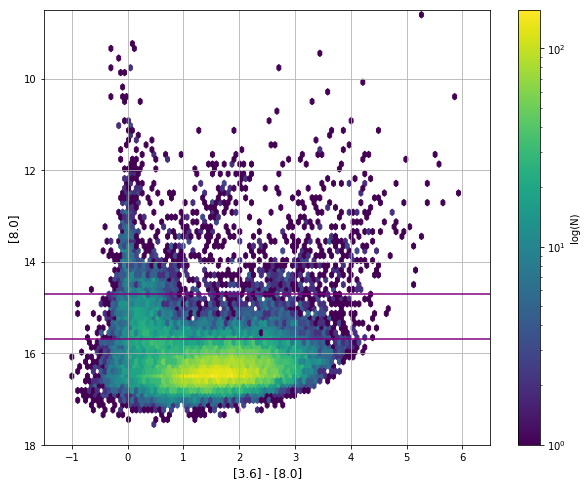

In [7]:
# 7
# all sources from the "ALL" .csv file, which I know I can't use
# because I can't run bogus photometry through KDE
#
# IN OTHER WORDS, THIS IS THE ~~~WRONG~~~ CMD TO USE!

# [8.0] vs [3.6]-[8.0]
# CMD & Hess diagram
#
plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroALL.threesixMINUSeightzero, threesixMINUSeightzeroALL.k80mag, ',')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(threesixMINUSeightzeroALL.threesixMINUSeightzero, threesixMINUSeightzeroALL.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')
plt.grid(True)
plt.show()
plt.close()

In [43]:
# 8

# The second thing I'll do is determine where the TRGB should be.
#
# With the Sibbons+ data I had a reference point, but with the Khan+ data
# I'm starting from scratch.
#
# To do so, I'll isolate only the photometric data of sources with
# errors in the magnitudes less than 0.1.

low_error_threesixMINUSeightzeroDATA = threesixMINUSeightzeroDATA[(threesixMINUSeightzeroDATA.e36mag < 0.2) & (threesixMINUSeightzeroDATA.e80mag < 0.2)]

# And as a check, see what the number of sources is for the entire catalog
# versus the number of sources in this trimmed catalog.

print(len(threesixMINUSeightzeroDATA))
print(len(low_error_threesixMINUSeightzeroDATA))

# 24 Feb 2019 addition:
# There are two different .csv files that I've uploaded for this CMD,
# one of which is all data with non-bogus photometric data,
# the other retaining ~1000 sources with e80mag = -999
# which throws off the whole damn thing.
#
# These are "DATA" and "ALL", respectievly.
#
# I think "DATA" is the correct catalog to use,
# but I'm including "ALL" for completeness.
#
# But that means I have to duplicate the analyses...

low_error_threesixMINUSeightzeroALL = threesixMINUSeightzeroALL[(threesixMINUSeightzeroALL.e36mag < 0.1) & (threesixMINUSeightzeroALL.e80mag < 0.1)]

print(len(threesixMINUSeightzeroALL))
print(len(low_error_threesixMINUSeightzeroALL))

20414
13464
30703
9174


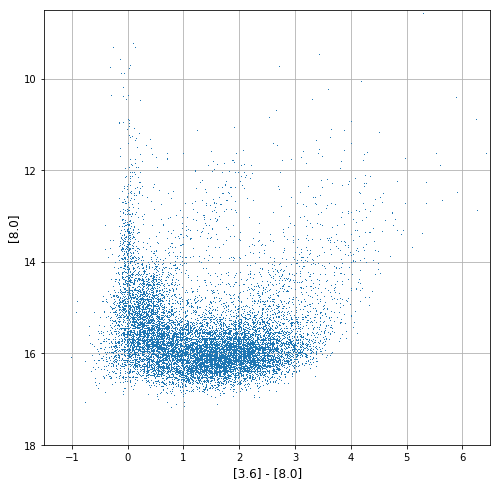

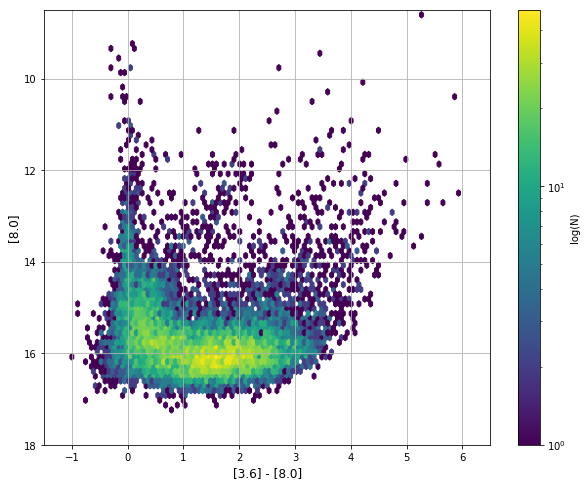

In [44]:
# 9

# With my catalog of only low-error photometry sources, I'll make a
# new CMD and Hess diagram just to see how the data look now.

# [8.0] vs [3.6]-[8.0] (low error)
# CMD & Hess diagram
#
plt.figure(figsize=(8, 8))
plt.plot(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, ',')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
#plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
plt.grid(True)
plt.show()
plt.close()
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
#plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')
plt.grid(True)
plt.show()
plt.close()

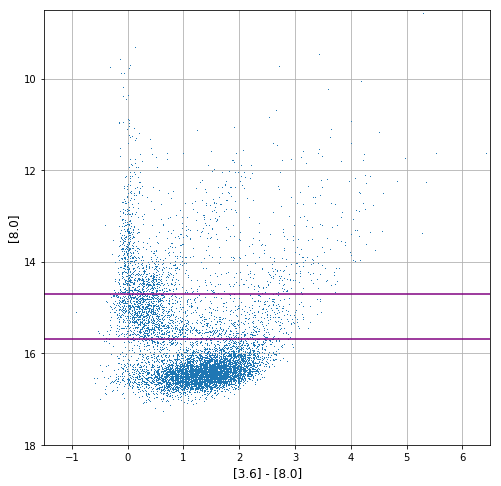

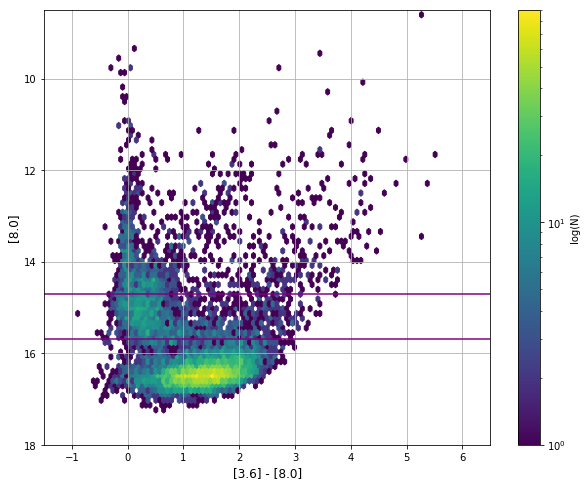

In [10]:
# 10
# This CMD has the e80mag = -9999 data included still
#
### YEAH THAT'S NO GOOD, I CAN'T RUN BOGUS PHOTOMETRY THROUGH KDE

# [8.0] vs [3.6]-[8.0] (low error)
# CMD & Hess diagram
#
plt.figure(figsize=(8, 8))
plt.plot(low_error_threesixMINUSeightzeroALL.threesixMINUSeightzero, low_error_threesixMINUSeightzeroALL.k80mag, ',')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
plt.grid(True)
plt.show()
plt.close()
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(low_error_threesixMINUSeightzeroALL.threesixMINUSeightzero, low_error_threesixMINUSeightzeroALL.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.axhline(y=15.681, linewidth=1.5, color='purple') # TRGB threshold - all data
plt.axhline(y=14.715, linewidth=1.5, color='purple') # TRGB threshold - low error data
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')
plt.grid(True)
plt.show()
plt.close()

In [11]:
# 11

# Definitely looks cleaner than before.
#
# I'll use this trimmed catalog to develop the color cuts themselves,
# but the full catalog when I'm doing the actual source identification.
#
##################################################
#
# At this point, the techniques from my previous methodology are going
# to be modified, in the sense that I'll still be implementing a KDE-style
# Gaussian fit to the resulting histograms and finding the values of the
# local minima, but we'll be including the photometric uncertainties into
# the Gaussians to be more statistically robust.
#
# Furthermore, the position of the TRGB itself will now no longer be
# determined by finding a trough in the histogram (and subsequently finding
# the local minimum's position), but instead a technique more similar to how
# Sibbons et al. (2012) found their TRGB. <- *Sobel Edge Detection Technique*
#
# Instead of finding a trough's minimum, they computed where the slope of the
# Gaussian most steeply falls off, which is indicative of where in color space
# there is a rapid change of stellar population demographics.
#
# It has the net effect of including more stars into the range of our boundaries,
# being more consistent with what TRGB value Sibbons+ came up with (which makes
# sense for K vs J-K since it's all only the same photometric data), and since
# determination of this coordinate is automated (based on the fit's derivative),
# finding the TRGB value in all the other CMDs will be more robust AND faster!
#
# In order to determine the color-cut boundaries, however, I have a concern about
# what coordinate value is decided upon:
#
# If it's the edge (where the derivative is maximum), and we're looking for the
# local minima, could we compute the edges for either side, then take an average?
#
# Also, how do I program a Sobel edge detection?
#
# ^ Sundar wrote something based on previous work done by Peter Scicluna.

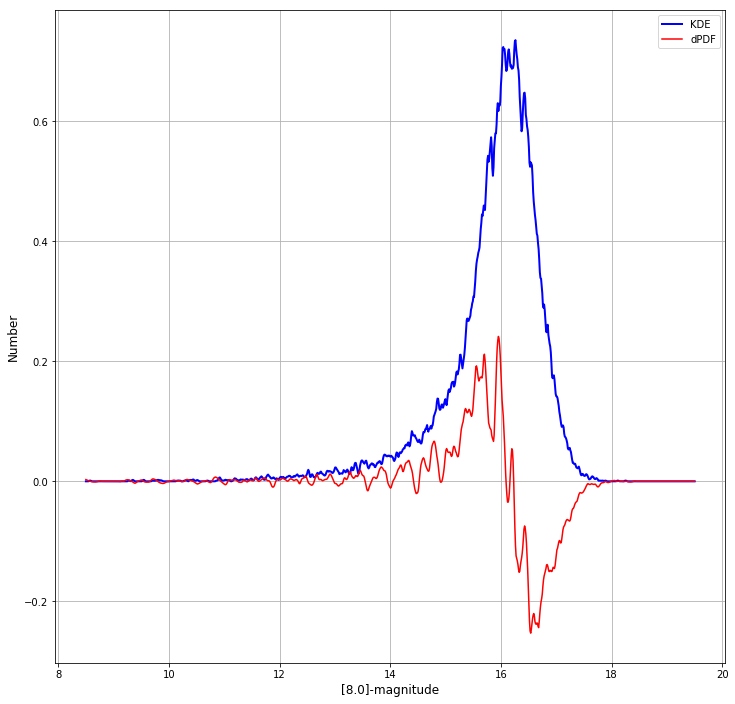

In [12]:
# 12

# This cell shows the non-MC KDE for TRGB determination.
#
# We used this to inform how the multiple realizations of the method
# would work out, even though the MCKDE code looks a bit different.
#
# Once I make the vertical magnitude span bins, I intend to copy
# the code from this cell in order to determine where the breaks
# are in between stellar types, rather than the original KDE
# syntax that was supplied to me by Owen Boberg last year.
#
# If I can't figure out how to get it to work, however, I will fall back
# on the method I used pre-AAS meeting.

def getdata():
    infile = 'threesixMINUSeightzero.csv'
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('k80mag', 'f8'), ('e80mag', 'f8'), ('threesixMINUSeightzero', 'f8'), ('ERRORthreesixMINUSeightzero', 'f8')]) 
    m = table['k80mag']
    dm = table['e80mag']
    return m, dm

def doplot(x, pdfx, dpdfx, data = 0):
    plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2., label = 'KDE', color='blue')
#    if data != 0:
#        plt.hist(data, bins = bins, normed = True, label = 'Binned data')
#    plt.xlim(xlim)
    plt.plot(x, dpdfx*20, 'k', lw = 1.5, label = 'dPDF', color='red')
    plt.legend()
    plt.xlabel('[8.0]-magnitude', size=12)
    plt.ylabel('Number', size=12)
    plt.grid(True)
    plt.show()
    plt.close()

def main():

    #Read from input table into variables m and dm
    m, dm = getdata()

    #Initialise stuff
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    #mx = np.linspace(min(m)*0.8, max(m)*1.2, 1000)
    mx = np.linspace(8.5, 19.5, 1000)
    #Generate NITER realisations of the KDE

#    for i in range(niter):
    msamp = np.random.normal(m, dm)
    #print(min(msamp))
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
    bandwidth_factor = 0.25
    bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
    kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
    kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
    pdf = kde.score_samples(mx[:, np.newaxis])
    pdf = np.exp(pdf)
    dpdf = np.gradient(pdf, mx[1] - mx[0]) #mx is equally spaced, provide the spacing as the x difference.
    from scipy.signal import savgol_filter
    pdfsm = savgol_filter(pdf, 3, 2, deriv = 0)
    dpdfsm = savgol_filter(pdf, 31, 3, deriv = 1) #smoothing window should be somehow related to resolution used for x axis
 #       #Plotting
    doplot(mx, pdf, dpdfsm)
    #print(pdf)
    #print(bandwidth)
 #       #Use PDF to do stuff (e.g., detect edges)
 #       #result = do_stuff(pdf)
 #       #Store results of ith iteration
 #       #
 #       #

main()


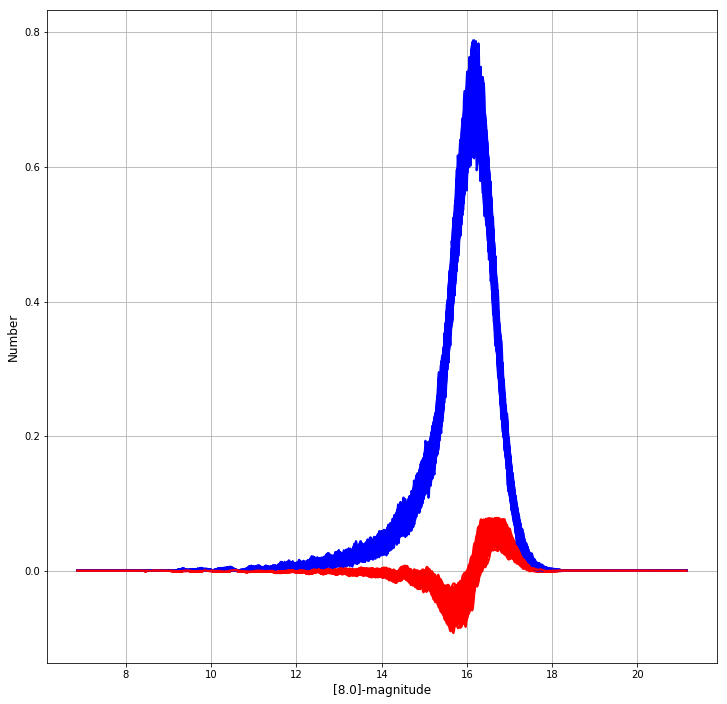

(15.678462222222224, 0.11545493272147517)

In [13]:
# 13

# This cell contains the MCKDE code routine to find the TRGB
# which we are intending on implementing for finding the breaks
# between different stellar types.
#
# Our problem so far has been twofold:
#
# (1) By realizing each time a thousand times, we are giving the
#     analysis a large number of opportunities to explore unlikely
#     paths, and so the resulting unertainties are extremely large.
#
#     Sundar has talked to Peter about this, realizing that what
#     we really should do is find the "natural width" of the
#     distributions, which is an estimate of the standard deviations,
#     which is the 68% spread.
#
# (2) The Savitzky-Golay filter (rather than Sobel filter) is used
#     to determine where the maxima in derivative to the Epanechnikov
#     curve fit to the data is located, which is fine for finding the
#     TRGB, but is less obviously usable for finding the local minima
#     of inflection points.

import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy.signal import savgol_filter

def getdata(infile = 'threesixMINUSeightzero.csv', magname = 'k80mag', dmagname = 'e80mag'):
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('k80mag', 'f8'), ('e80mag', 'f8'), ('threesixMINUSeightzero', 'f8'), ('ERRORthreesixMINUSeightzero', 'f8')]) 
    m = table[magname]
    dm = table[dmagname]
    return m, dm

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlabel('[8.0]-magnitude', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'threesixMINUSeightzero.csv', magname = 'k80mag', dmagname = 'e80mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
    m, dm = getdata(infile = infile)

    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


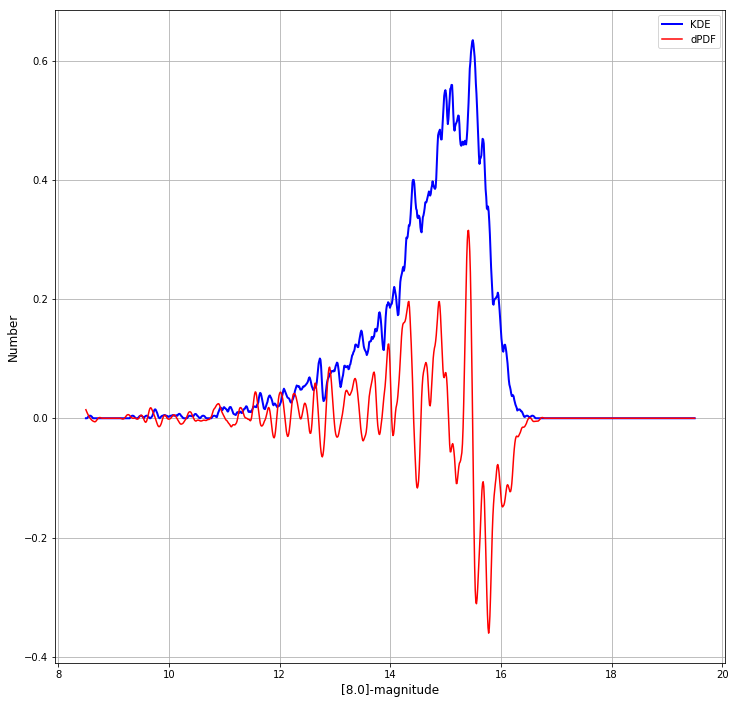

In [14]:
# 14
# low-error TRGB find test

# This cell shows the non-MC KDE for TRGB determination.
#
# We used this to inform how the multiple realizations of the method
# would work out, even though the MCKDE code looks a bit different.
#
# Once I make the vertical magnitude span bins, I intend to copy
# the code from this cell in order to determine where the breaks
# are in between stellar types, rather than the original KDE
# syntax that was supplied to me by Owen Boberg last year.
#
# If I can't figure out how to get it to work, however, I will fall back
# on the method I used pre-AAS meeting.

def getdata():
    infile = 'threesixMINUSeightzero.csv'
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('k80mag', 'f8'), ('e80mag', 'f8'), ('threesixMINUSeightzero', 'f8'), ('ERRORthreesixMINUSeightzero', 'f8')]) 
    m = table['k80mag']
    dm = table['e80mag']
    return m, dm

def doplot(x, pdfx, dpdfx, data = 0):
    plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2., label = 'KDE', color='blue')
#    if data != 0:
#        plt.hist(data, bins = bins, normed = True, label = 'Binned data')
#    plt.xlim(xlim)
    plt.plot(x, dpdfx*20, 'k', lw = 1.5, label = 'dPDF', color='red')
    plt.legend()
    plt.xlabel('[8.0]-magnitude', size=12)
    plt.ylabel('Number', size=12)
    plt.grid(True)
    plt.show()
    plt.close()

def main():

    #Read from input table into variables m and dm
    #m, dm = getdata(infile = infile)

    m = low_error_threesixMINUSeightzeroDATA.k80mag
    dm = low_error_threesixMINUSeightzeroDATA.e80mag

    #Initialise stuff
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    #mx = np.linspace(min(m)*0.8, max(m)*1.2, 1000)
    mx = np.linspace(8.5, 19.5, 1000)
    #Generate NITER realisations of the KDE

#    for i in range(niter):
    msamp = np.random.normal(m, dm)
    #print(min(msamp))
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
    bandwidth_factor = 0.25
    bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
    kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
    kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
    pdf = kde.score_samples(mx[:, np.newaxis])
    pdf = np.exp(pdf)
    dpdf = np.gradient(pdf, mx[1] - mx[0]) #mx is equally spaced, provide the spacing as the x difference.
    from scipy.signal import savgol_filter
    pdfsm = savgol_filter(pdf, 3, 2, deriv = 0)
    dpdfsm = savgol_filter(pdf, 31, 3, deriv = 1) #smoothing window should be somehow related to resolution used for x axis
 #       #Plotting
    doplot(mx, pdf, dpdfsm)
    #print(pdf)
    #print(bandwidth)
 #       #Use PDF to do stuff (e.g., detect edges)
 #       #result = do_stuff(pdf)
 #       #Store results of ith iteration
 #       #
 #       #

main()


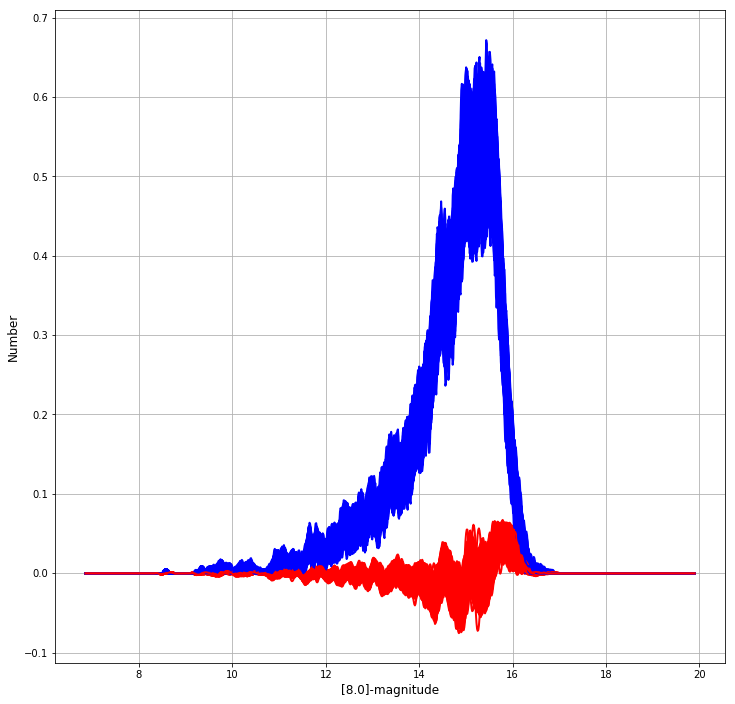

(14.70614623423423, 0.29138487892050197)

In [15]:
# 15
# low-error TRGB find test

# This cell contains the MCKDE code routine to find the TRGB
# which we are intending on implementing for finding the breaks
# between different stellar types.
#
# Our problem so far has been twofold:
#
# (1) By realizing each time a thousand times, we are giving the
#     analysis a large number of opportunities to explore unlikely
#     paths, and so the resulting unertainties are extremely large.
#
#     Sundar has talked to Peter about this, realizing that what
#     we really should do is find the "natural width" of the
#     distributions, which is an estimate of the standard deviations,
#     which is the 68% spread.
#
# (2) The Savitzky-Golay filter (rather than Sobel filter) is used
#     to determine where the maxima in derivative to the Epanechnikov
#     curve fit to the data is located, which is fine for finding the
#     TRGB, but is less obviously usable for finding the local minima
#     of inflection points.

import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy.signal import savgol_filter

def getdata(infile = 'threesixMINUSeightzero.csv', magname = 'k80mag', dmagname = 'e80mag'):
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('k80mag', 'f8'), ('e80mag', 'f8'), ('threesixMINUSeightzero', 'f8'), ('ERRORthreesixMINUSeightzero', 'f8')]) 
    m = table[magname]
    dm = table[dmagname]
    return m, dm

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlabel('[8.0]-magnitude', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'threesixMINUSeightzero.csv', magname = 'k80mag', dmagname = 'e80mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
    #m, dm = getdata(infile = infile)

    m = low_error_threesixMINUSeightzeroDATA.k80mag
    dm = low_error_threesixMINUSeightzeroDATA.e80mag
    
    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


In [16]:
# 16
# low-error TRGB find test (including e80mag = -9999 data)

##################################################
# OH WAIT! LOOKS LIKE I FIGURED OUT THE PROBLEM! #
##################################################

# I can't run the KDE/MCKDE analysis on the data with
# e80mag = -9999 because then the whole routine crashes.

# I guess that means that I'll have to stick to the
# input .csv where I've cleared out all of the bogus
# photometric data!

# Anything based off of the file
# "eightzeroMINUSthreesixALL.csv"
# is bad news.

##################################################
# OH WAIT! LOOKS LIKE I FIGURED OUT THE PROBLEM! #
##################################################

# This cell shows the non-MC KDE for TRGB determination.
#
# We used this to inform how the multiple realizations of the method
# would work out, even though the MCKDE code looks a bit different.
#
# Once I make the vertical magnitude span bins, I intend to copy
# the code from this cell in order to determine where the breaks
# are in between stellar types, rather than the original KDE
# syntax that was supplied to me by Owen Boberg last year.
#
# If I can't figure out how to get it to work, however, I will fall back
# on the method I used pre-AAS meeting.

def getdata():
    infile = 'threesixMINUSeightzero.csv'
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('k80mag', 'f8'), ('e80mag', 'f8'), ('threesixMINUSeightzero', 'f8'), ('ERRORthreesixMINUSeightzero', 'f8')]) 
    m = table['k80mag']
    dm = table['e80mag']
    return m, dm

def doplot(x, pdfx, dpdfx, data = 0):
    plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2., label = 'KDE', color='blue')
#    if data != 0:
#        plt.hist(data, bins = bins, normed = True, label = 'Binned data')
#    plt.xlim(xlim)
    plt.plot(x, dpdfx*20, 'k', lw = 1.5, label = 'dPDF', color='red')
    plt.legend()
    plt.xlabel('[8.0]-magnitude', size=12)
    plt.ylabel('Number', size=12)
    plt.grid(True)
    plt.show()
    plt.close()

def main():

    #Read from input table into variables m and dm
    #m, dm = getdata(infile = infile)

    m = low_error_threesixMINUSeightzeroALL.k80mag
    dm = low_error_threesixMINUSeightzeroALL.e80mag

    #Initialise stuff
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    #mx = np.linspace(min(m)*0.8, max(m)*1.2, 1000)
    mx = np.linspace(8.5, 19.5, 1000)
    #Generate NITER realisations of the KDE

#    for i in range(niter):
    msamp = np.random.normal(m, dm)
    #print(min(msamp))
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
    bandwidth_factor = 0.25
    bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
    kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
    kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
    pdf = kde.score_samples(mx[:, np.newaxis])
    pdf = np.exp(pdf)
    dpdf = np.gradient(pdf, mx[1] - mx[0]) #mx is equally spaced, provide the spacing as the x difference.
    from scipy.signal import savgol_filter
    pdfsm = savgol_filter(pdf, 3, 2, deriv = 0)
    dpdfsm = savgol_filter(pdf, 31, 3, deriv = 1) #smoothing window should be somehow related to resolution used for x axis
 #       #Plotting
    doplot(mx, pdf, dpdfsm)
    #print(pdf)
    #print(bandwidth)
 #       #Use PDF to do stuff (e.g., detect edges)
 #       #result = do_stuff(pdf)
 #       #Store results of ith iteration
 #       #
 #       #

main()


ValueError: scale < 0